# BLU05 - Learning Notebook - Part 2 of 3 - SARIMAX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import gauss
from random import seed
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
seed(1)
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_absolute_error

import utils
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import stattools
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from utils import load_electricity_consumption_series
from utils import load_airlines_series
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 6)


In [2]:
airlines = utils.load_airline_data()

In [3]:
airlines_logged = airlines.map(np.log)

In [4]:
airlines_logged_diff = airlines_logged.diff()

## 1. ARIMA 

[ARIMA](http://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html) is one of the most used models for predicting timeseries. There are more sophisticated versions that we will get to later, but for now we'll use the plain vanilla version to develop some intuitions. 

ARIMA stands for: 

- (AR) Auto Regressive 
- (I)  Integrated 
- (MA) Moving Average

The names are, [imho](https://www.urbandictionary.com/define.php?term=IMHO), a bit misleading, let's go into them in more detail. 

About the model API, it elegantly depends only on 3 parameters: 

> `ARIMA(p,d,q)`

Notes: 
- _The results of our predictions in this notebook will suck, as we are trying to avoid adding complexity, and showcase the API._ 
- _If you want to try the hardcore version, [this article](https://people.duke.edu/~rnau/411arim.htm) has a very well made explanation for many cases of ARIMA. We are, as mentioned, going to stick to the super-basic "get your hands dirty" ARIMA._
- _If you are feeling scared with how to select hyper parameters for ARIMA remember that in the real world hyper parameter optimizers can take care of most of this. This notebook shows things as they were in the time where programmers had nothing but a dusty book, a magnetized needle and a steady hand. However getting these intuitions will help you debug and explain your models later._ 

### 1.1 Auto regressive 

The first of our 3 parameters, `p`, is the "number of auto-regressive terms". 

What are auto-regressive terms? They are quite simply the lags of the dependent variable. Is the present point dependent on the previous one? On the previous two? Eight? 

In plain English, the auto-regressive model says that: 
> “The value at a particular time depends on the value at the previous times (+ error)” 

To use this model (we'll use just an AR model, and then add the other components to see the difference), we need to choose the parameter `p`, and use the model as `ARIMA(p, 0, 0)`. 

##### Choosing the hyper-parameter `p`

Choosing the parameter `p`, as with just about everything in data science, is a mixture of heuristics and experience. 

Sometimes, you have a strong business reason to say "I want to only use the previous p lags". In others, you want to use the data to tell you. 

Given that in this case we don't have much of a business intuition about airline passengers (at least I don't), we will use the PACF (partial auto-correlation function) to determine a suitable value. 

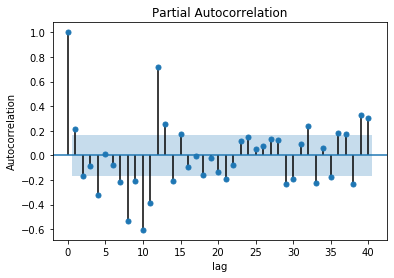

In [5]:
plot_pacf(airlines_logged_diff.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

The standard way to decide p is to use the table below. What is cutt off and tail off you ask? Cut off means there is an abrupt decrease to 0 after a certain lag. Tail off means the autocorrelation is slowly decreasing over time. This [stack exchange question](https://stats.stackexchange.com/questions/241914/terms-cut-off-and-tail-off-about-acf-pacf-functions) has an interesting discussion about it.

|      |         AR(p)        |         MA(q)        | ARMA(p,q) |
|:----:|:--------------------:|:--------------------:|:---------:|
|  ACF |       Tails off      | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p |       Tails off      | Tails off |

In our case there doesn't seem to be a cut off neither a tail off, so this time series should have both AR and MA processes. In this case how do we choose the `p`? Well, there's a rule of thumb to choose the lag before the first lag within the confidence interval. For example, lag 2 is already within the confidence interval (not completely, but let's consider so) so we'll go with lag 1, thus `p`=1. Also, don't forget that the first lag is the 0, then lag 1 is still outside the bonds, then 2 is almost within, so we consider it is. Again, there is not absolute answer, later you'll learn a method to obtain the best parameters.

In [6]:
model = ARIMA(airlines_logged_diff.dropna().values, order=(1, 0, 0))
results = model.fit();

A few of things to note about the API:
1. We passed the data straight to the model (unlike in sklearn) 
2. We used .values to get the numpy array instead of the pandas series ([this is how we're now all feeling](https://i.imgflip.com/2a3tym.jpg))
3. We passed the order `(p, d, q)` as `(1, 0, 0)`, as we'd established that we want to try `p=1`
4. We called `fit` without any parameters (which is also different from sklearn) 
5. The model isn't fit in place, we have to grab the results with a results
6. We got some annoying FutureWarnings. Nothing to worry about, but will pollute your screen. 

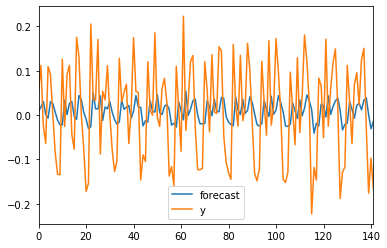

In [7]:
results.plot_predict()
plt.show()

Also, you're probably wondering why the model did so poorly, right? Well, it clearly looks like this is not a pure AR process. This means that the last previous values of the time series alone do not explain the present value.

### 1.2 Integrated 

The "integrated" part of the name simply means that we take the diff between consecutive periods to make the time series stationary. We've already done this ahead of time (because we needed it for our ACF and PACF plots), but you can also leave it as a hyper parameter and tune it later. 

The name "integrated" is something that, to be completely honest, baffles me. My guess is that they didn't want to say "differentiated" because the model would then be `ARDMA`, but that isn't a bad name. At the end of the day, some would claim that the reasons [might never be clear](https://i.imgflip.com/2a3kk1.jpg). 

Anyway, to change the parameter `d`, we follow the same logic as before. Let's set `p` to 1, and try a few values of `d`: 

In [8]:
# making the plot smaller, so that the notebook doesn't seem as large an scary 

In [9]:
def try_parameter_d(data, d):
    model = ARIMA(data, order=(1, d, 0))
    results = model.fit();
    results.plot_predict()
    plt.show()

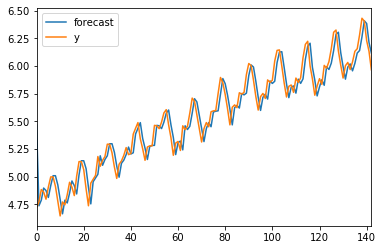

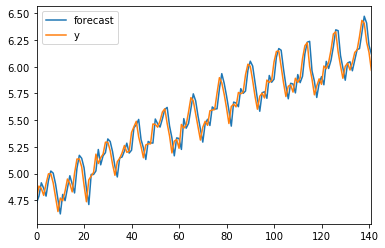

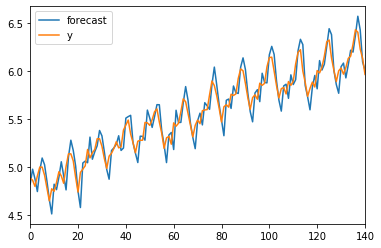

In [10]:
# notice that we are passing the original logged data, and letting d diff it as it needs
try_parameter_d(airlines_logged.astype(float).values, 0)
try_parameter_d(airlines_logged.astype(float).values, 1)
try_parameter_d(airlines_logged.astype(float).values, 2)

It seems that `d`=1 obtains the best prediction, which makes sense because the data clearly has a trend. 

### 1.2 Moving Average 

The last of our 3 parameters, `q`, is the "number of moving average terms". 

The logic here is similar to the one we used for `p`, but instead of predicting values with lagged values, we are predicting errors with lagged errors. 

The MA terms are lagged forecast errors. In this model, what predicts `x(t)` is `e(t-1)`, `e(t-2)`, ..., where `e(i)` is the difference between the moving average at the ith instant and the actual value.

In plain English, the moving average model says that: 
> _“your function at a particular time is your error at that time, plus a parameter theta times your error at a previous time”_

##### Choosing the hyper-parameter `q`

Yay! Anoyher hyper parameter! 

The rule of thumb for setting `q` is to ~~`use a hyper-parameter optimizer because it's 2018, AWS is cheap and life is short`~~ use the ACF. The reasons are not trivial, and are well explained in [this fantastic StackExchange post](https://stats.stackexchange.com/questions/281666/how-does-acf-pacf-identify-the-order-of-ma-and-ar-terms?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa), if you are interested in digging deeper. 

If not, just remember: 
> For `p` use the PACF  
> For `q` use the ACF. 

So, let's plot our ACF: 

In [11]:
# quick adjustment to plot sizes for clarity 
plt.rcParams["figure.figsize"] = (20,7)

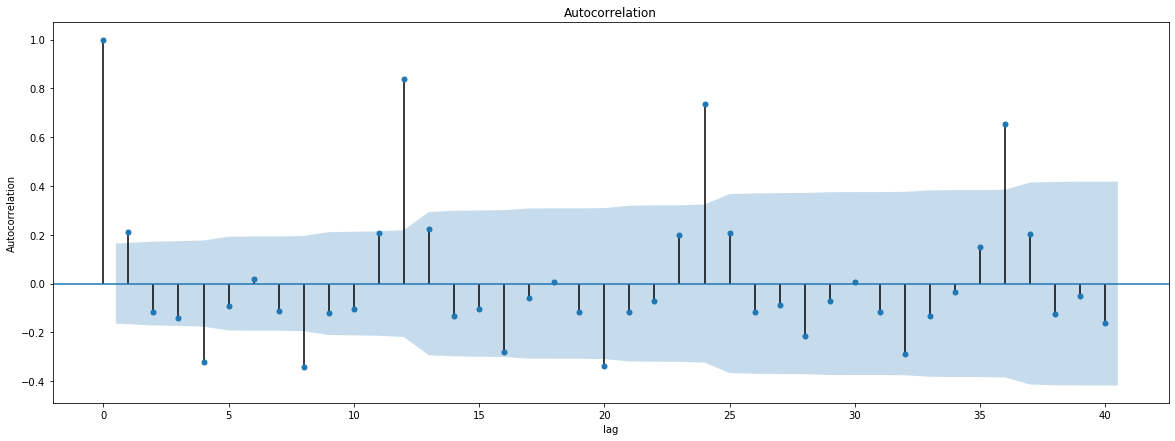

In [12]:
plot_acf(airlines_logged_diff.dropna(), alpha=.05, lags=40)  
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

As before, lags 2 is already within the confidence interval, so we'll just go with `q`=1

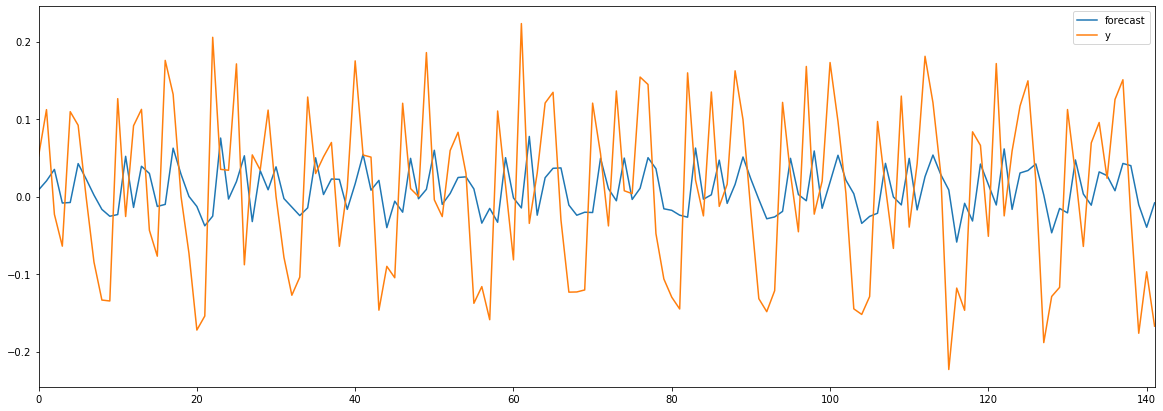

In [13]:
model = ARIMA(airlines_logged_diff.dropna().values, order=(0, 0, 1))
results = model.fit();
results.plot_predict()
plt.show()

Note that the ACF and PACF plots were computed on the stationary timeseries, this is important not to forget.

### 1.4 Result

Great, so now we know how to use the Auto Regressive model, the Moving Average model, and how to control how much differentiation goes on. It only remains to put it all together, and have some fun. 

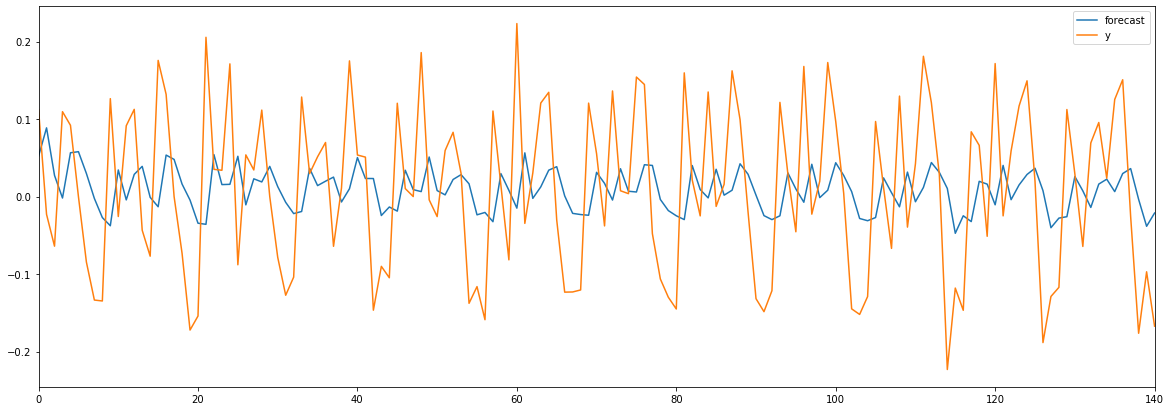

In [14]:
model = ARIMA(airlines_logged_diff.dropna().values, order=(1, 1, 1))
results = model.fit();
results.plot_predict()
plt.show()

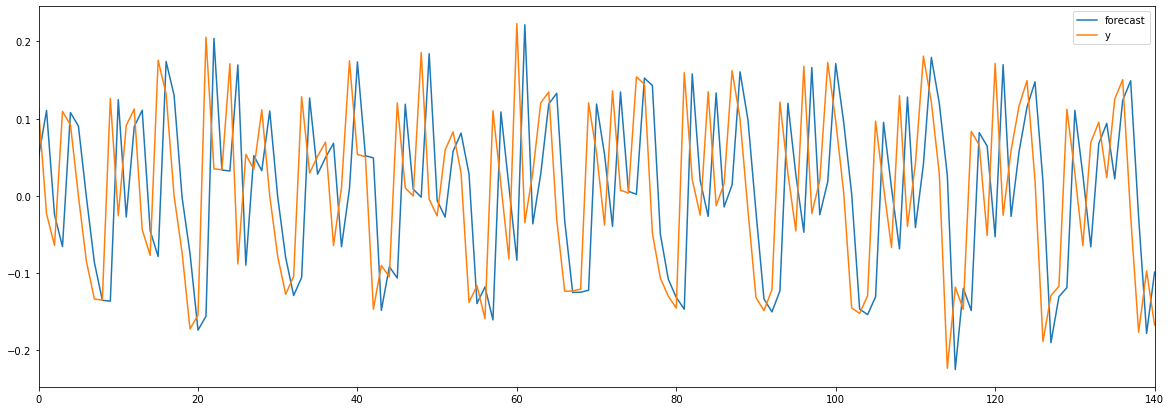

In [15]:
model = ARIMA(airlines_logged_diff.dropna().values, order=(0, 1, 0))
results = model.fit();
results.plot_predict()
plt.show()

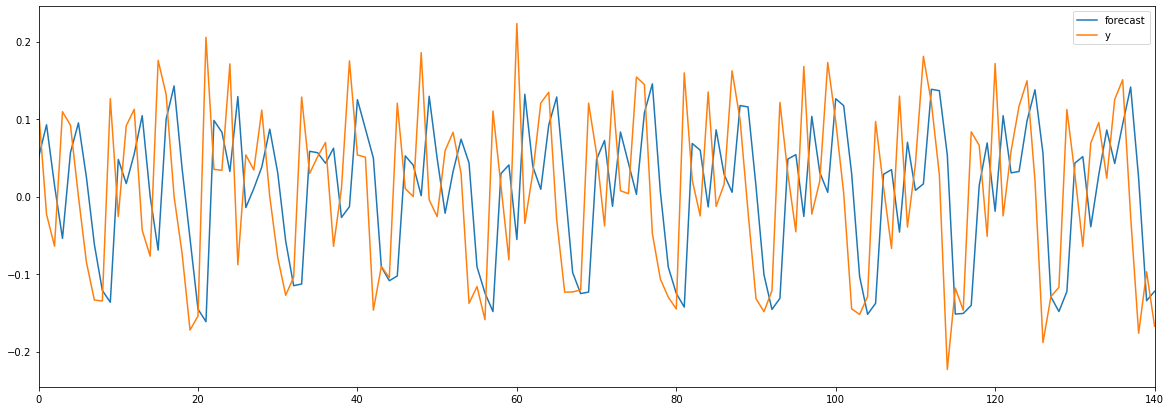

In [16]:
model = ARIMA(airlines_logged_diff.dropna().values, order=(1, 1, 0))
results = model.fit();
results.plot_predict()
plt.show()

#### Undoing the transformations 

One last, but critical point, is how to undo our transformations. As you might have noticed, the plots we made don't actually predict the number of passengers, they predict... some weird logged thing differentiated twice. 

- **Undoing the diff:** Sum the original logged timeseries shifted by one lag and drop nans.
- **Undoing the log:** Apply the exponential.

#### Excellent, so let's rebuild our own predictions

In [17]:
# make some quick and dirty predictions (ignore the quality of them for now)
model = ARIMA(airlines_logged_diff.dropna().values, order=(2, 0, 2))
results = model.fit();

# Get the series of results. These are our un-transformed predictions 
predictions_after_one_diff_and_a_log = pd.Series(results.predict(), index=airlines.index[1:])

# Re-build the logged predictions from the diff of the logged predictions 
predictions_after_a_log = predictions_after_one_diff_and_a_log + np.log(airlines).shift(1).dropna()

# Re-build the predictions from the log of the predictions 
predictions = predictions_after_a_log.map(np.exp)

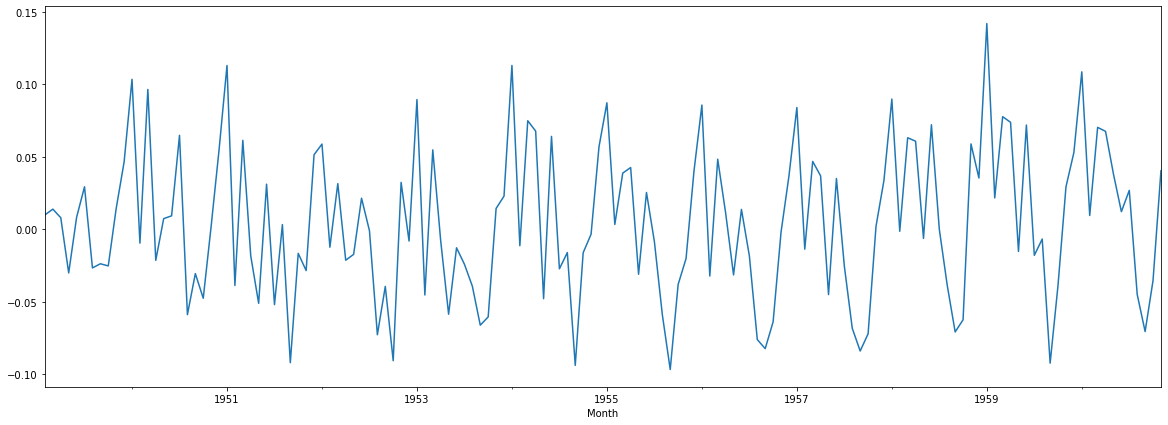

In [18]:
predictions_after_one_diff_and_a_log.plot();

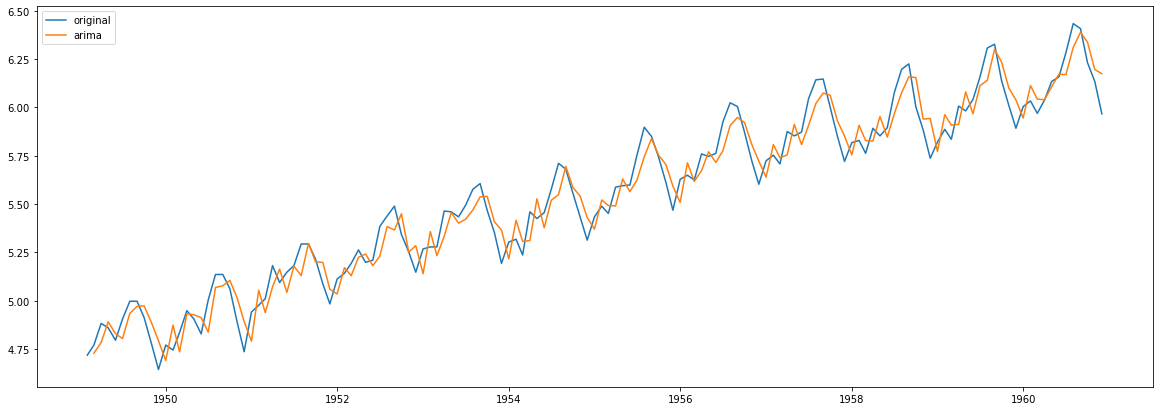

In [19]:
plt.plot(airlines_logged, label='original')
plt.plot(predictions_after_a_log, label='arima')
plt.legend()
plt.show();

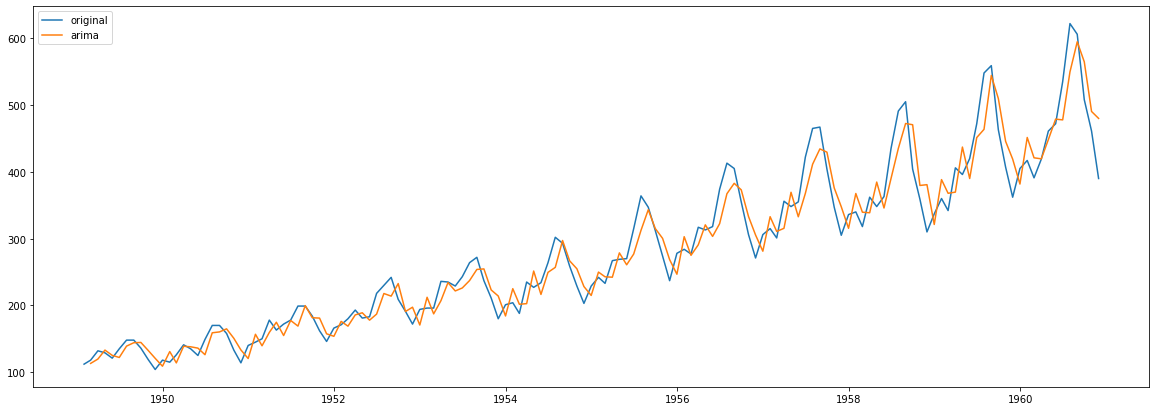

In [20]:
plt.plot(airlines, label='original')
plt.plot(predictions, label='arima')
plt.legend()
plt.show();

Hmm not too bad, but not perfect either. Also, there seems to be some seasonality in there that we're not taking into account with our current model. We'll have to use the SARIMAX!

## 2. SARIMAX

This is the SARIMAX. What does that stand for? 

![](https://i.imgflip.com/2ab2xu.jpg)

The **Autoregressive Integrated Moving Average** part we already know. _(well... kind of anyway)_ 

Now what about the new bits? 

- **`Seasonal`**: as the name suggests, this model can actually deal with seasonality. Coool.... 
- **`With Exogenous`** roughly means we can add external information. For instance we can include the temperature time series to predict the ice cream sales, which is surely useful. Exogenous variables are explained better a bit later.

What are the parameters? 

The ones below we already know. **Also note that now we're going to use d=1 to avoid having to difference the time series, and then transforming it back**. Also note that we still have to log the data, since SARIMAX can't do that by itself.
> p = 1  
> d = 1  
> q = 1  



But now we have a second bunch. The first 3 are analagous to the previous ones, but for the seasonal part. There are also guidelines on how to chose them, but for now we'll just use the following: 
> P = 1  
> D = 1  
> Q = 1  

The last new parameter, `S`, is an integer giving the periodicity (number of periods in season). 
We normally have a decent intuition for this parameter: 
- If we have daily data and suspect we may have weekly trends, we may want `S` to be 7. 
- If the data is monthly and we think the time of the year may count, maybe try `S` at 12 

In our case, looking at the acf we can see strong correlation with lag 12, 24, 36, etc. thus indicating yearly seasonality! Hence:
> S = 12   

To know the SARIMAX in detail you can and should take a closer look at [the documentation](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html). But for now, let's just do exactly what we did before, but without the crazy low level details: 

### 2.1 Seasonality

In [21]:
model = SARIMAX(airlines_logged,             # <-- holy crap just passed it pandas? No ".values"? No .diff?
                          order=(1, 1, 1),              # <-- keeping our order as before
                          seasonal_order=(1, 0, 1, 12)) # <-- We'll get into how we found these hyper params later 

Now to fit the model 

In [22]:
results = model.fit(maxiter=100)

And get predictions: 

In [23]:
pred = results.get_prediction()

In [24]:
predictions = pred.predicted_mean

print('Can this possibly return a... %s  OH MY GOD IT DID THAT IS SO AWESOME!!' % type(predictions))

Can this possibly return a... <class 'pandas.core.series.Series'>  OH MY GOD IT DID THAT IS SO AWESOME!!


Done. Seriously, check this out: 

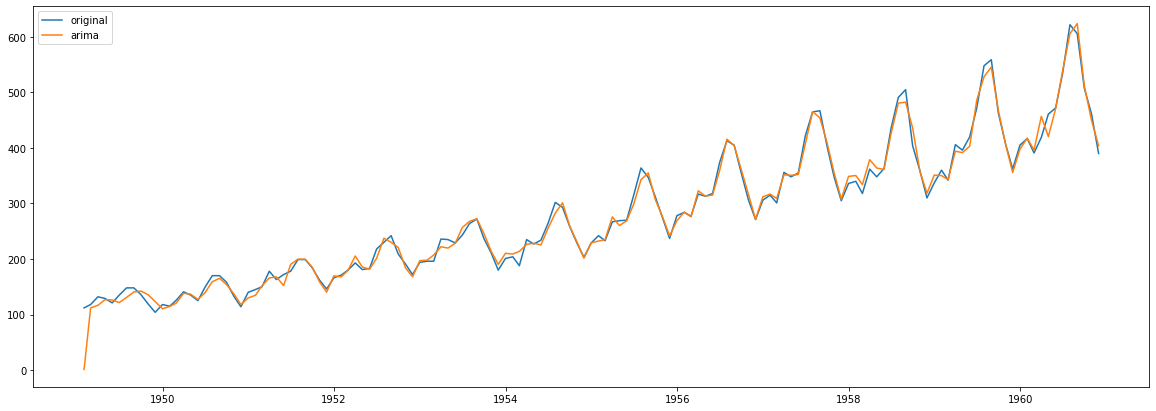

In [25]:
plt.plot(airlines, label='original')
plt.plot(np.exp(predictions), label='arima')
plt.legend()
plt.show();

### 2.2 Causality

When talking about modelling in geral we often refer to dependent and indepedent variables, as you have learned. But there is another nomenclature for the relations between different variables which is specially useful in timeseries. This nomenclature is based on the causal relation between the variables. Correlation does not imply causation. If you don't remember why, check this [website](https://www.tylervigen.com/spurious-correlations). Even if you do remember, do yourself a favor and check it. So what is this nomenclature? Basically it splits variables into endogenous or exogeneous, whose differences are detailed below.

#### Endogenous Variable

From [Merriam Webster](https://www.merriam-webster.com/dictionary/endogenous), *2.a : caused by factors inside the organism or system*. In other words, an endogenous variable is a variable whose value is determined by the model you are using to predict a time series. It is like a feedback loop: your model will use values that it produced in previous predictions. It is an input signal that comes from the model that produces that same signal. When you use this type of variables, you are assuming that the next values of a time series will depend on previous values of that same time series.

#### Exogenous Variable

From [Merriam Webster](https://www.merriam-webster.com/dictionary/exogenous), *introduced from or produced outside the organism or system; specifically : not synthesized within the organism or system*. These are variables/features that aren't predicted by the model you build nor is it affected by predictions your model makes. This type of feature is believed to have an impact on what you want to predict but, no matter what the prediction you make, the exogenous variable won't be affected.

You might be wondering "Aren't those endogenous equal to dependent variables and exogenous equal to independent variables?". The answer is **no**. Let me give you an example to show you the difference: imagine you have a model that predicts the price of a product based on (1) demand and (2) past price values. You might be tempted to think that (1) is exogenous and (2) is endogenous. But economists know that if you lower the price of a good, people will be more open to acquire more of it. And, as such, the demand is not independent the predictions your model does, even more if you use those predictions to set the price. You can still use the demand as an exogenous variable but you will break the assumption of independence between the prediction and the exogenous variable. If you do that, don't tell us that you weren't warned about it.

Another example: when predicting the stock value for a specific company, the stock values of previous days are the **endogenous variables** while descriptors like the number of employees, number of products, number of clients are the **exogenous variables**.

So, as we mentioned before SARIMAX allows you to add exogenous variables. Let's add some crazy exogenous variable your airlines example. What about the US consumption growth? 

In [26]:
# don't worry too much about this, I'm just wrangling another dataset to use it with our airlines dataset
data = pd.read_csv('data/US_Production_Q_Data_Growth_Rates.csv')
data.Year = pd.to_datetime(data.Year)
data = data.set_index('Year')
us_consumption_growth = data.iloc[:,6].resample('M').mean().fillna(method='ffill')['1949-01-31':'1960-11-30']

In [27]:
# add our exogenous variable
model = SARIMAX(airlines_logged, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), exog = us_consumption_growth)
results = model.fit(maxiter=100);

predictions = results.get_prediction().predicted_mean


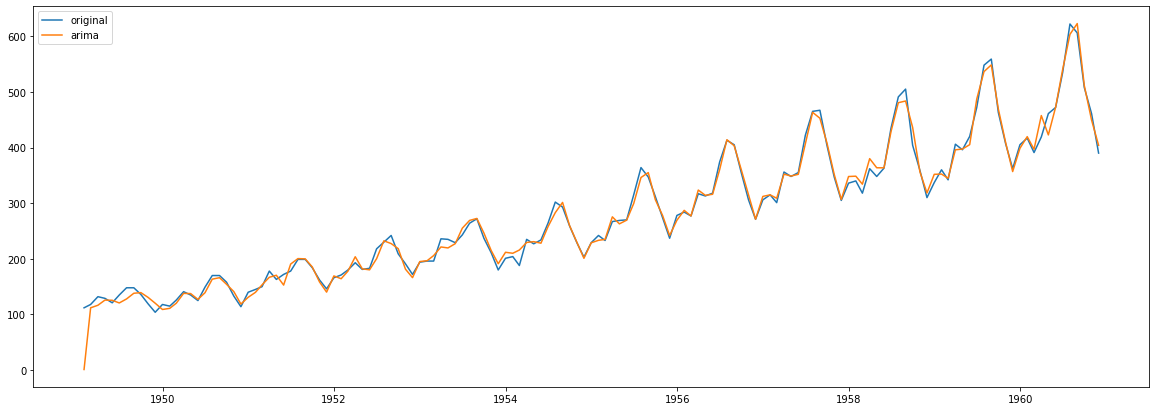

In [28]:
plt.plot(airlines, label='original')
plt.plot(np.exp(predictions), label='arima')
plt.legend()
plt.show();

Well, didn't seem to help much, since this plot is quite similar to the one above. So did the exogneous feature actually improve anything? There must be better ways to evaluate the quality of our predictions than looking at plots...

## 3. Validation

The standard metric for timeseries claisscal models is the AIC (Akaike information criterion), which is a metric that will simutaneously measure how well the model fits the data, but will control for how complex the model is. If the model is very complex, the expectation on how well it must fit the data will also go up. It is therefore useful for comparing models. 

If you (for some weird reason) feel compelled to calculate it by hand, [this post](https://stats.stackexchange.com/questions/87345/calculating-aic-by-hand-in-r?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa) explains how to do so. Then again, it's sunny and beautiful outside, and Statsmodel has got your back. 


So let's calculate the AIC for our SARIMAX with and without the exogeneous variable!

In [29]:
model = SARIMAX(airlines_logged, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit();

predictions = results.get_prediction()
pred_ci = predictions.conf_int()
mean_predictions = predictions.predicted_mean

In [30]:
results.aic

-475.61322117374914

In [31]:
model = SARIMAX(airlines_logged, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=us_consumption_growth)
results = model.fit();

predictions = results.get_prediction()
pred_ci = predictions.conf_int()
mean_predictions = predictions.predicted_mean

In [32]:
results.aic

-478.8608491647814

Smaller is better, so the more negative the better. It seems that the exogeneous variable slightly helped, but in this case we're not interested in such a small improvement so we're going to continue with the non-exogeneous SARIMAX.

## 4. Hyper parameter optimization

So for tunning our hyper parameters we'll use AIC. There are also other metrics, such as R², but for that we'd need to create a validation set to avoid overfitting. Since AIC already penalizes complexity, we can use it without a validation set.

Let's build a Hyper Parameter Optimizer (fancy!) 

In [33]:
p = d = q = P = D = Q = range(0, 2)   #  <--- all of the paramters between 0 and 2 

S = [7, 12] # <-- let's pretend we have a couple of hypothesis 

In [34]:
params_combinations = list(itertools.product(p, d, q, P, D, Q, S))

In [35]:
inputs = [[x[0], x[1], x[2], x[3], x[4], x[5], x[6]] for x in params_combinations]

Great. Now, for each set of params, let's get the aic: 

In [36]:
def get_aic(series_, params):
    # extract the params 
    p = params[0] 
    d = params[1] 
    q = params[2] 
    P = params[3]
    D = params[4] 
    Q = params[5]
    S = params[6]
    
    # fit a model with those params 
    model = SARIMAX(series_,order=(p, d, q), seasonal_order=(P, D, Q, S),
                                     enforce_stationarity=False,
                                     enforce_invertibility=False)
    
    # fit the model
    results = model.fit(maxiter=200)
    
    # return the aic 
    return results.aic

Run, forest, run! 

In [37]:
%%time 

aic_scores = {}
params_index = {}

for i in range(len(inputs)):
    try: 
        param_set = inputs[i]
        aic = get_aic(airlines_logged, param_set) 
        aic_scores[i] = aic
        params_index[i] = param_set
    
    # this will fail sometimes with impossible parameter combinations. 
    # ... and I'm too lazy to remember what they are. 
    except Exception as e: 
        continue

/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/base/mo

CPU times: user 26.9 s, sys: 50.1 ms, total: 27 s
Wall time: 27 s


Wrangle these results into a usable dataframe 

_(note: don't worry if you don't understand this code too well for now)_

In [38]:
temp = pd.DataFrame(params_index).T
temp.columns = ['p', 'd', 'q', 'P', 'D', 'Q', 'S']
temp['aic'] = pd.Series(aic_scores)
temp.sort_values('aic').head()

,p,d,q,P,D,Q,S,aic
91,1,0,1,1,0,1,12,-473.139346
107,1,1,0,1,0,1,12,-470.382665
59,0,1,1,1,0,1,12,-468.021113
75,1,0,0,1,0,1,12,-467.586308
123,1,1,1,1,0,1,12,-466.520152


Great! What were the best params? 

In [39]:
best_model_params = temp.aic.idxmin()
temp.loc[best_model_params]

p        1.000000
d        0.000000
q        1.000000
P        1.000000
D        0.000000
Q        1.000000
S       12.000000
aic   -473.139346
Name: 91, dtype: float64

Wait, `d`=0 and `D`=0 ? But the series clearly has a trend! Good point, the thing is that here we're only doing one-step predictions. Basically, this means that the effect of the trend is not meaningful when you're predicting just the next step. Which makes sense, the trend is specially important for multi-step predictions as we'll see later.

Great! Let's fit that model then: 

In [40]:
best_model = SARIMAX(airlines_logged,
                                      order=(1, 0, 1),
                                      seasonal_order=(1, 0, 1, 12))

results = best_model.fit()
predictions_best_model = results.get_prediction()

/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/felgueira/anaconda3/envs/BLU05/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


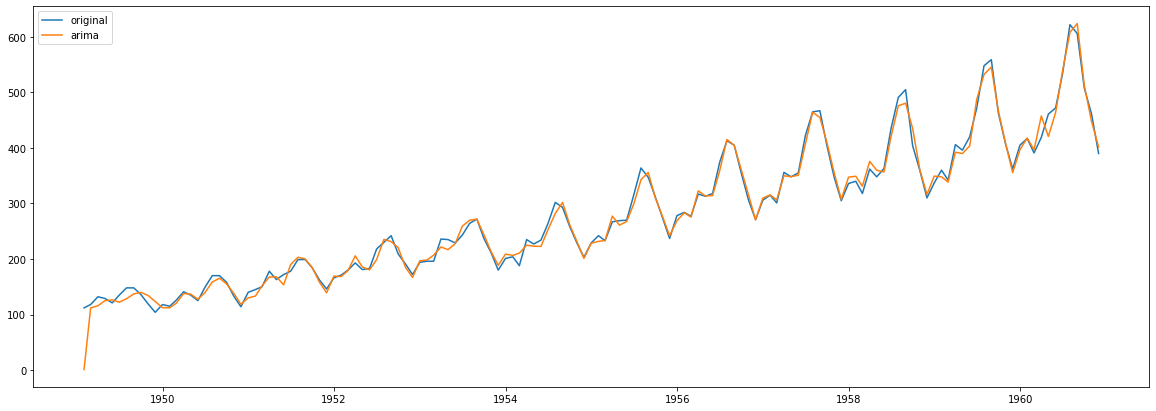

In [41]:
plt.plot(airlines, label='original')
plt.plot(np.exp(predictions_best_model.predicted_mean), label='arima')
plt.legend()
plt.show();

Meh, not too different from the one we got by eye.

### Evaluation

To understand how good our model is we should compare it with a baseline, the most common one is normally called _Persistence_. The predictions of this model correspond to the last seen value of the time series, hence the name persistence. It simply predicts that the next value will be the last one it has seen. To simulate this model we simply have to shift the original time series.

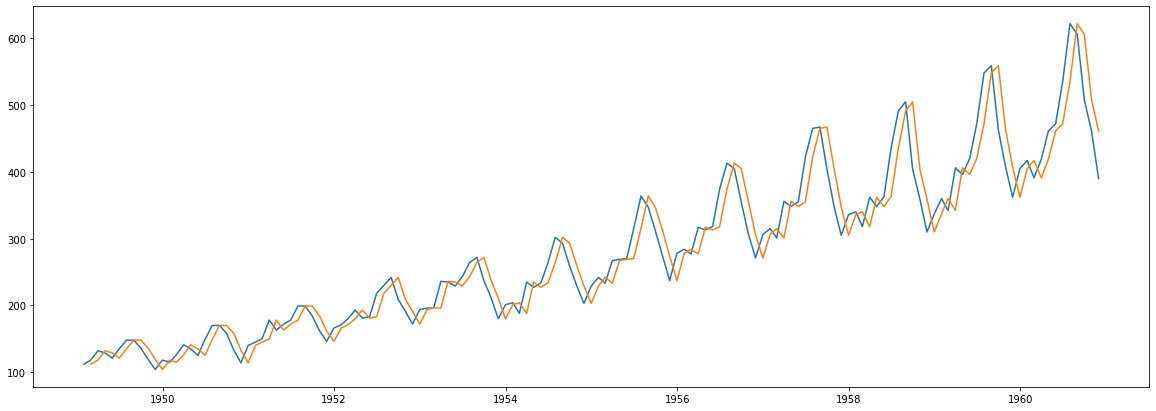

In [42]:
plt.plot(airlines, label='original')
plt.plot(airlines.shift(1).dropna(), label='arima')
plt.show();

Just by eye we can see that this seems quite worse than our SARIMAX. Let's quantify it using MSE, as you've learned in the bootcamp.

In [43]:
mean_absolute_error(airlines[1:],airlines.shift(1).dropna())

25.746478873239436

In [44]:
mean_absolute_error(airlines[1:],np.exp(predictions_best_model.predicted_mean)[1:])

8.391914416588348

Note that we don't consider the first value, because this is impossible to predict

That's a very big difference! Seems like SARIMAX is quite useful indeed.

Uf, that was intensive. But now you're the master of one-step time series forecasting! 

> "Wait, what? One-step?"

Uh... yhea, didn't you notice that until now you were just predicting the next step of the time series? So if it has monthly frequency, you were predicting the value for the next month.

> "You mean there's even more to forecast?"

Yup, multi-step forecasting, here we go!